In [0]:
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal

In [0]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [0]:
class gan_gen:
    def __init__(self,name,generate_real_samples,generate_latent_points,n_epochs,n_eval,latent_dim,n_inputs,is_3d=True,combined_plot=False):    
        self.name = name
        self.generate_real_samples = generate_real_samples
        self.generate_latent_points = generate_latent_points     
        self.n_epochs = n_epochs     
        self.n_eval = n_eval     
        self.latent_dim = latent_dim
        self.n_inputs = n_inputs
        self.is_3d = is_3d
        self.combined_plot = combined_plot
        
    # define the combined generator and discriminator model, for updating the generator
    def define_gan(self,generator, discriminator):
        # make weights in the discriminator not trainable
        discriminator.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(generator)
        # add the discriminator
        model.add(discriminator)
        # compile model
        model.compile(loss='binary_crossentropy', optimizer='adam')        
        return model
      
    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self,generator, latent_dim, n):
      # generate points in latent space
      x_input = generate_latent_points(latent_dim, n)
      # predict outputs
      X = generator.predict(x_input)
      # create class labels
      y = zeros((n, 1))
      return X, y  
    
    def train(self,g_model, d_model, gan_model, latent_dim, n_epochs, n_eval, n_batch=64):
        print("parameters latent_dim:",latent_dim, " epochs " ,n_epochs," summary :", n_eval," batch ", n_batch)
        # determine half the size of one batch, for updating the discriminator
        half_batch = int(n_batch / 2)
        
        counter = 0

        losses_discriminator_real = []
        losses_discriminator_fake = []
        losses_generator = []
        real_values = []
        fake_values = []
        acc_discriminator_real = []
        acc_discriminator_fake = []
        # manually enumerate epochs
        for i in range(n_epochs):
            # prepare real samples
            x_real, y_real = self.generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = self.generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator
            d_model.train_on_batch(x_real, y_real)
            d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = self.generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            gan_model.train_on_batch(x_gan, y_gan)
            # evaluate the model every n_eval epochs
            if (i+1) % n_eval == 0:
                g_loss  = gan_model.test_on_batch(x_gan, y_gan)
                losses_generator.append(g_loss)
                
                counter = counter + 1
                performance_metrics = self.summarize_performance(counter,i, g_model, d_model, latent_dim) 
                losses_discriminator_real.append(performance_metrics[0] )
                losses_discriminator_fake.append(performance_metrics[1] )
                acc_discriminator_real.append(performance_metrics[4] )
                acc_discriminator_fake.append(performance_metrics[5] )
                real_values.append(performance_metrics[2] )
                fake_values.append(performance_metrics[3] )
        pyplot.show()        
        if self.combined_plot :
          self.draw_plots2d(real_values,fake_values,"x")
        else :
          self.draw_plots(real_values,"real ")
          self.draw_plots(fake_values,"fake ")
        
        return (losses_generator,losses_discriminator_real,losses_discriminator_fake,real_values,fake_values,acc_discriminator_real,acc_discriminator_fake)
                
    # evaluate the discriminator and plot real and fake points
    def summarize_performance(self,counter,epoch, generator, discriminator, latent_dim, n=200):
        # prepare real samples
        x_real, y_real = self.generate_real_samples(n)
        # evaluate discriminator on real examples
        loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)        
        # prepare fake examples
        x_fake, y_fake = self.generate_fake_samples(generator, latent_dim, n)
        # evaluate discriminator on fake examples
        loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)                
        return [loss_real,loss_fake,x_real,x_fake,acc_real,acc_fake]
        
        
    def define_discriminator(self,n_inputs):
        model = Sequential()
        lrel = LeakyReLU(alpha=0.3)

        model.add(Dense(25, activation=lrel, kernel_initializer='he_uniform', input_dim=n_inputs))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
 
    # define the standalone generator model
    def define_generator(self,latent_dim):
        model = Sequential()
        init = RandomNormal(mean=0.0, stddev=0.02)
        lrel = LeakyReLU(alpha=0.3)
        model.add(Dense(30, activation=lrel, kernel_initializer=init, input_dim=latent_dim))
        model.add(Dense(self.n_inputs, activation='linear'))
        return model    
        
    def run(self):
        # size of the latent space
         
        # create the discriminator
        discriminator = self.define_discriminator(self.n_inputs)
        # create the generator
        generator = self.define_generator(self.latent_dim)
        # create the gan
        gan_model = self.define_gan(generator, discriminator)
        # train model
        losses = self.train(generator, discriminator, gan_model,self.latent_dim, self.n_epochs,self.n_eval)
        self.draw_loss( losses )
        return losses
      
    def draw_loss(self,losses):    
      fig, ax = plt.subplots()
      plt.plot(losses[0], label='Generator')
      plt.plot(losses[1], label='Discriminator Real')
      plt.plot(losses[2], label='Discriminator Fake')
      plt.title("Training Losses")
      plt.legend()
      plt.show()
      fig, ax = plt.subplots()
      plt.plot(losses[5], label='Acc Real')
      plt.plot(losses[6], label='Acc Fake')
      plt.title("Training Acc")
      plt.legend()
      plt.show()
      
    def draw_plots(self,milestone_points,label):
      if  self.is_3d :
        self.draw_plots3d(milestone_points,label)
      else :
        self.draw_plots2d(milestone_points,label)


    def draw_plots3d(self,milestone_points,label):
      #plt.figure(figsize=(20,20)) 
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestone_points)):    
        points = milestone_points[i]
        ax = fig.add_subplot(5,5,i+1, projection='3d')
        ax.set_title(label+str(i+1))
        ax.scatter(points[:,0:1],points[:,1:2],points[:,2] , c='r', zorder=10) 
              

    def draw_plots2d(self,milestones1,milestones2,label):
      #plt.figure(figsize=(20,20)) 
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestones1)):    
        points1 = milestones1[i]
        points2 = milestones2[i]
        ax = fig.add_subplot(5,5,i+1)
        ax.set_title(label+str(i+1))
        ax.scatter(points1[:,0:1],points1[:,1:2]) 
        ax.scatter(points2[:,0:1],points2[:,1:2]) 
                

In [0]:
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input      
    


def generate_real_samples(n):
  # generate inputs in [-0.5, 0.5]
  X1 = rand( n) * 2 - 1
  #print(X1.shape)
  
  X2 = X1 * 2
  
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

First let's try a **week architecture**. 
Here latent_dim is only 3 so network is weak. Subsequent runs show greate difference. This shows random parameter initialization makes big difference.

parameters latent_dim: 3  epochs  100  summary : 10  batch  64


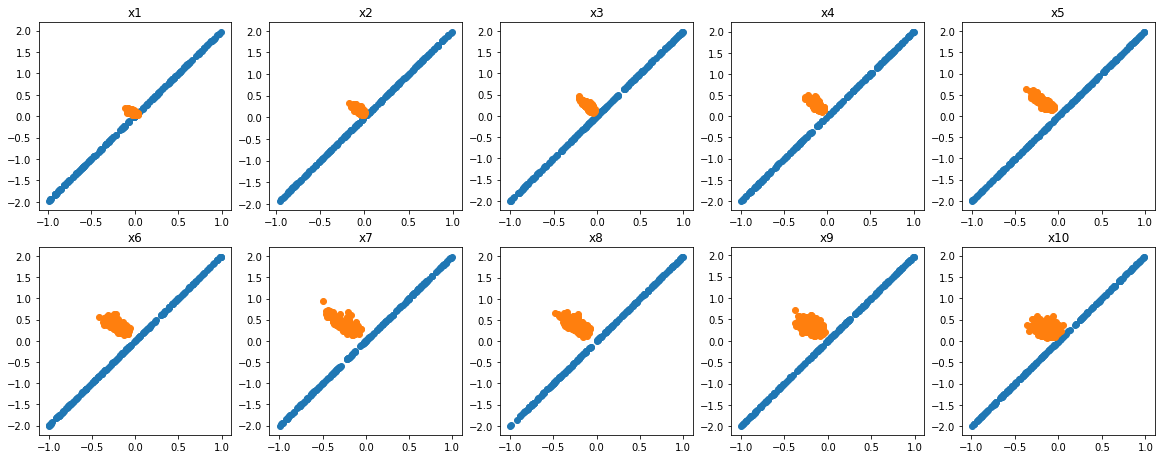

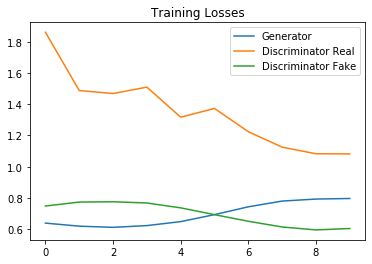

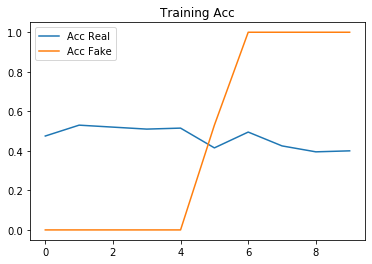

In [41]:
gan = gan_gen("step ",generate_real_samples,generate_latent_points,n_epochs=100,n_eval=10 ,latent_dim=3,n_inputs=2 ,is_3d=False,combined_plot=True )
res = gan.run() 

At below we execute weak network again and seems doing much better. But I got this after 2-3 trial. At every trial outputs differ so much.

parameters latent_dim: 3  epochs  100  summary : 10  batch  64


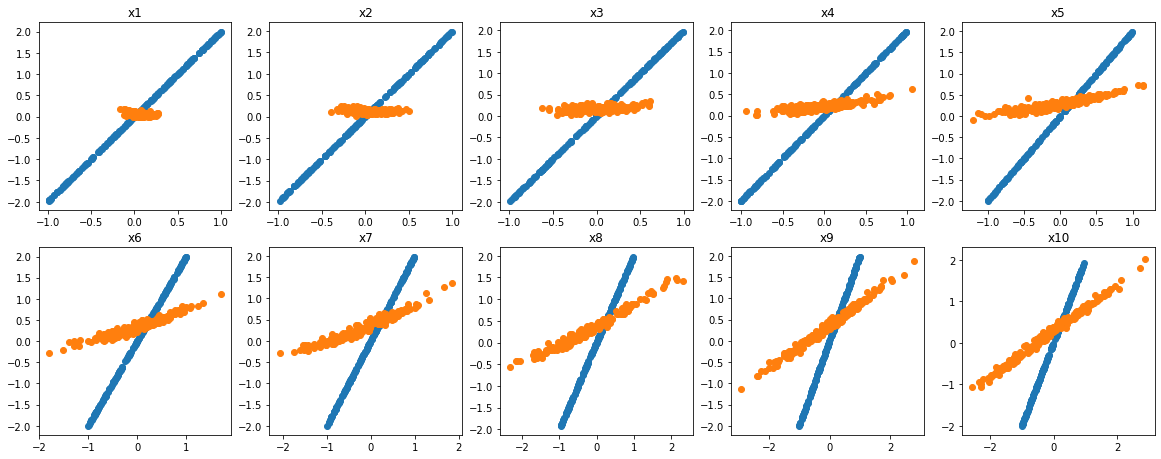

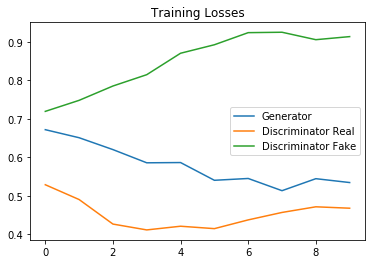

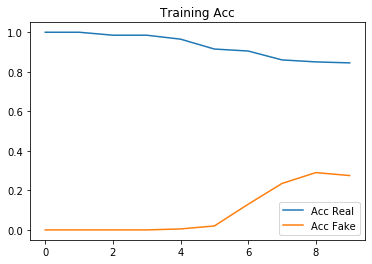

In [44]:
gan = gan_gen("step ",generate_real_samples,generate_latent_points,n_epochs=100,n_eval=10 ,latent_dim=3,n_inputs=2 ,is_3d=False,combined_plot=True )
res = gan.run() 

Now let's make network more powerfull. 

1.   Make more epochs
2.   Increase latent dim

1st let's try to do more epochs. At below you can see more epochs make network much powerful. As you can see at the end , both accuracy is around %50 which is our target for gans.


# More powerfull network

parameters latent_dim: 3  epochs  400  summary : 40  batch  64


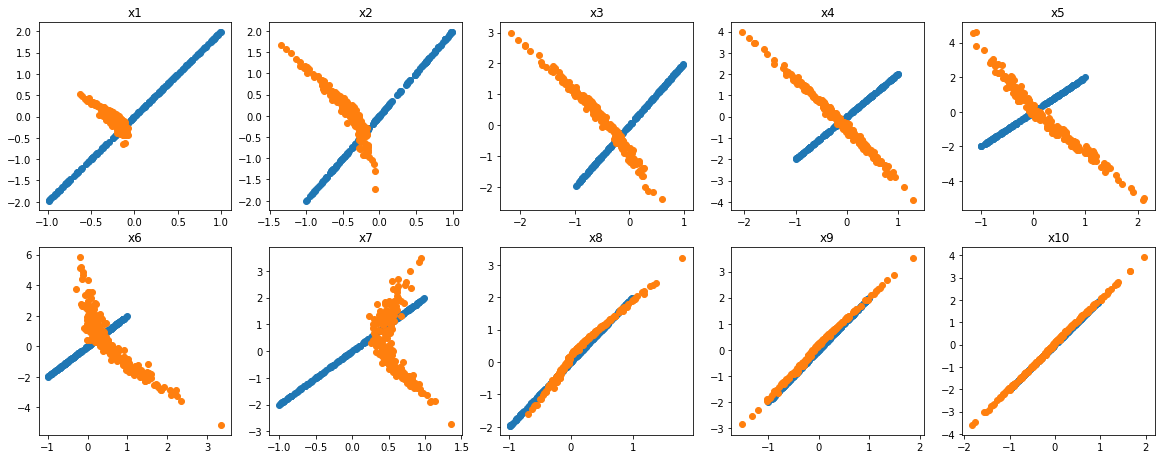

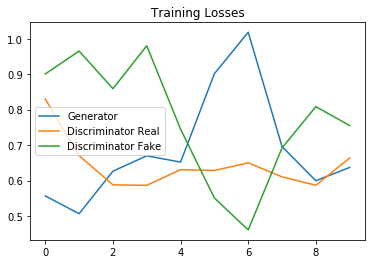

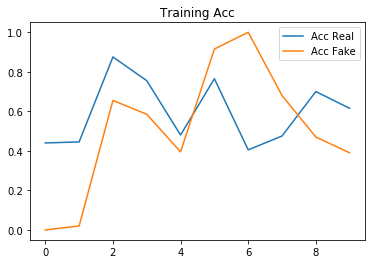

In [47]:
gan = gan_gen("step ",generate_real_samples,generate_latent_points,n_epochs=400,n_eval=40 ,latent_dim=3,n_inputs=2 ,is_3d=False,combined_plot=True )
res = gan.run() 

Now let's try to add generate more powerful network by dimension. More neurons make the same effect. Network now becomes able to model the distribution.

parameters latent_dim: 80  epochs  100  summary : 10  batch  64


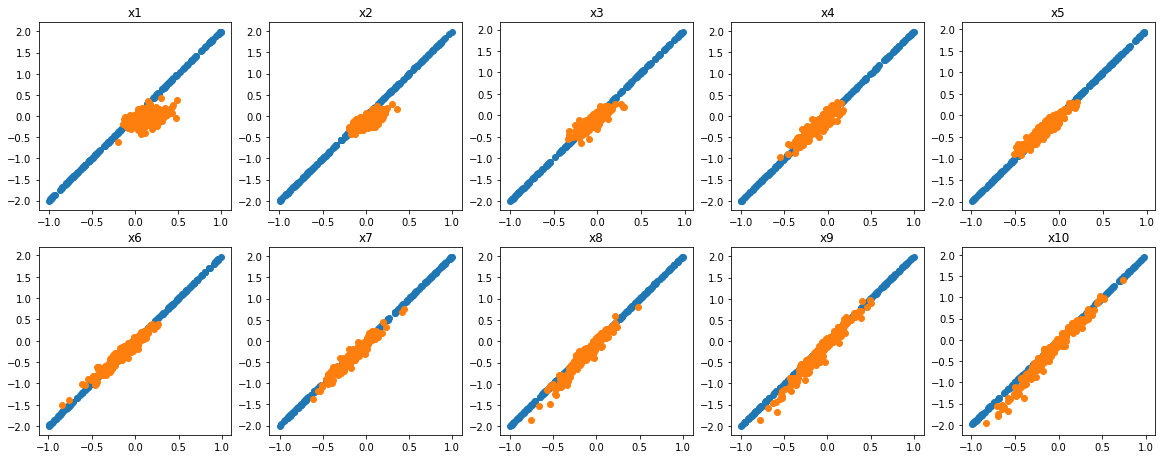

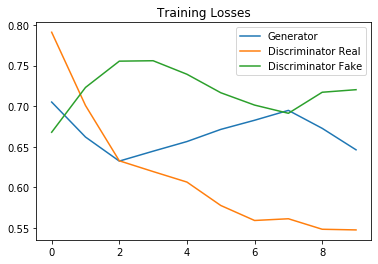

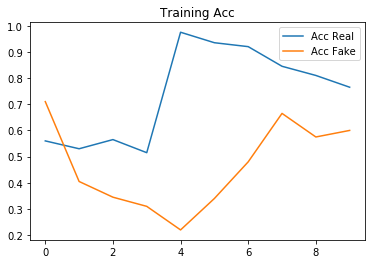

In [52]:
gan = gan_gen(" step ",generate_real_samples,generate_latent_points,n_epochs=100,n_eval=10 ,latent_dim=80,n_inputs=2 ,is_3d=False,combined_plot=True )
res = gan.run() 

When we make latent dim as 280, it begins to overfit and shows strange behaviors.

parameters latent_dim: 280  epochs  100  summary : 10  batch  64


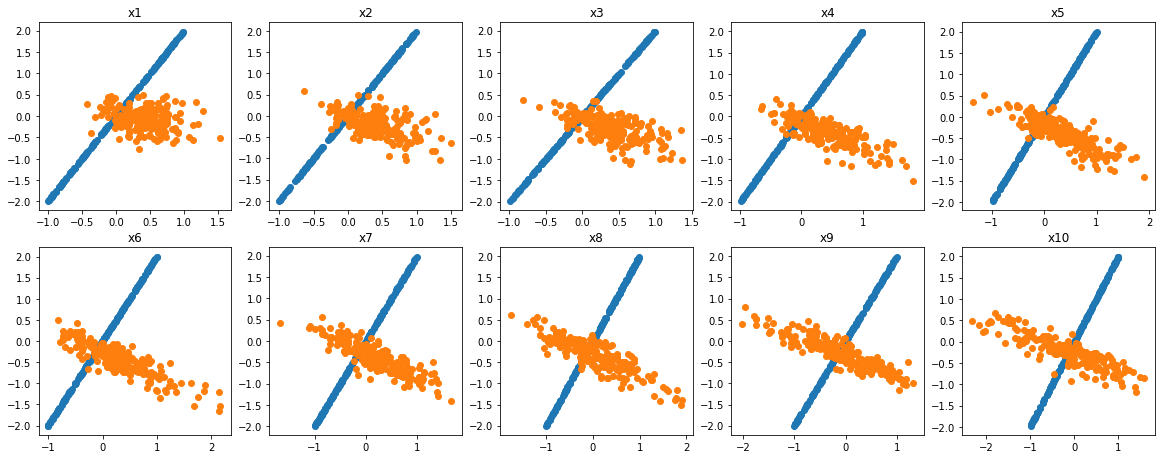

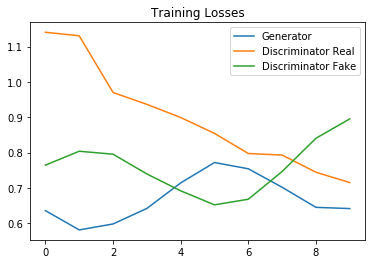

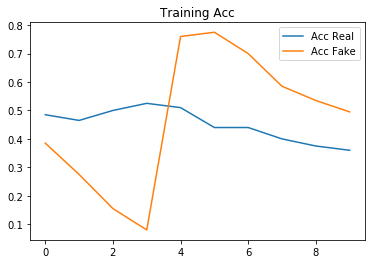

In [54]:
gan = gan_gen(" step ",generate_real_samples,generate_latent_points,n_epochs=100,n_eval=10 ,latent_dim=280,n_inputs=2 ,is_3d=False,combined_plot=True )
res = gan.run() 